In [10]:
import model as GAT
import pandas as pd
import os
import sys
import glob
import math
import matplotlib.pyplot as plt
import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap
import dgl
from scipy.spatial.distance import cdist
import networkx as nx
import numpy as np
import torch as nn


# Constructing the gene graph

In [11]:
gas_erthyroid_cell_df = pd.read_csv("../../data/GastrulationErythroid_cell_type_u_s.csv")
gas_erthyroid_cell_df


,gene_name,unsplice,splice,cellID,clusters,embedding1,embedding2
0,Sox17,0.000000,0.043971,cell_363,Blood progenitors 2,3.460521,15.574629
1,Sox17,0.000000,0.000000,cell_382,Blood progenitors 2,2.490433,14.971734
2,Sox17,0.000000,0.018161,cell_385,Blood progenitors 2,2.351203,15.267069
3,Sox17,0.000000,0.000000,cell_393,Blood progenitors 2,5.899098,14.388825
4,Sox17,0.000000,0.000000,cell_398,Blood progenitors 2,4.823139,15.374831
...,...,...,...,...,...,...,...
24657995,Gm47283,0.214961,1.145533,cell_139318,Erythroid3,8.032358,7.603037
24657996,Gm47283,0.300111,1.072944,cell_139321,Erythroid3,10.352904,6.446736
24657997,Gm47283,0.292607,1.199875,cell_139326,Erythroid3,9.464873,7.261099
24657998,Gm47283,0.266031,1.114659,cell_139327,Erythroid3,9.990495,7.243880


In [12]:
gene_list=['Smarca2', 'Rbms2', 'Myo1b', 'Hba-x', 'Yipf5', 'Skap1', 'Smim1', 'Nfkb1', 'Sulf2', 'Blvrb', 'Hbb-y', 'Coro2b', 'Yipf5', 'Phc2', 'Mllt3']
if gene_list is None:
    gene_list=list(gas_erthyroid_cell_df.gene_name.drop_duplicates())
else:
    cell_type_u_s=gas_erthyroid_cell_df[gas_erthyroid_cell_df.gene_name.isin(gene_list)]
    all_gene_name_cell_type_u_s=list(cell_type_u_s.gene_name.drop_duplicates())
    gene_not_in_cell_type_u_s= list(set(gene_list).difference(set(all_gene_name_cell_type_u_s)))
    gene_list=list(list(set(all_gene_name_cell_type_u_s).intersection(set(gene_list))))
    if len(gene_not_in_cell_type_u_s)>0: print(gene_not_in_cell_type_u_s," not in the data cell_type_u_s")

cell_type_u_s=cell_type_u_s.reset_index(drop=True)
gene_list_buring=[list(cell_type_u_s.gene_name.drop_duplicates())[0]]
print(gene_list_buring)

datamodule=GAT.build_datamodule(cell_type_u_s,False,True,0.125,True,gene_list=gene_list_buring) #type is feedData

for data_index in range(0,len(gene_list_buring)):
    print([data_index])
    selected_data = datamodule.subset([data_index])
    unsplice, splice, this_gene_name, unsplicemax, splicemax, embedding1, embedding2=selected_data.fit_dataset.__getitem__(0)
    print("selected data:")
    print(selected_data)
    print(unsplice.shape)
    print(splice.shape)
    print(this_gene_name)
    print(unsplicemax.shape)
    print(splicemax.shape)
    print(embedding1.shape)
    print(embedding2.shape)


['Myo1b']
[0]
selected data:
(270,)
(270,)
Myo1b
()
()
(270,)
(270,)


In [13]:
num_nodes = len(unsplice)
g = dgl.DGLGraph()

# Add nodes to the graph
g.add_nodes(num_nodes)

# Create pairs of values (unsplice_i, splice_i)
node_pairs = np.column_stack((unsplice, splice))

# Calculate Euclidean distances between all pairs of nodes
distances = cdist(node_pairs, node_pairs)
print(distances.shape)

# Iterate through each node and connect it to the closest nodes
for i in range(num_nodes):
    # Find the indices of the closest nodes (excluding itself)
    closest_indices = np.argsort(distances[i])[1:31]

    # Add edges between the current node and its closest neighbors
    g.add_edges(i, closest_indices)
    g.add_edges(closest_indices, i)

print("Graph", g)


(270, 270)
Graph Graph(num_nodes=270, num_edges=16200,
      ndata_schemes={}
      edata_schemes={})


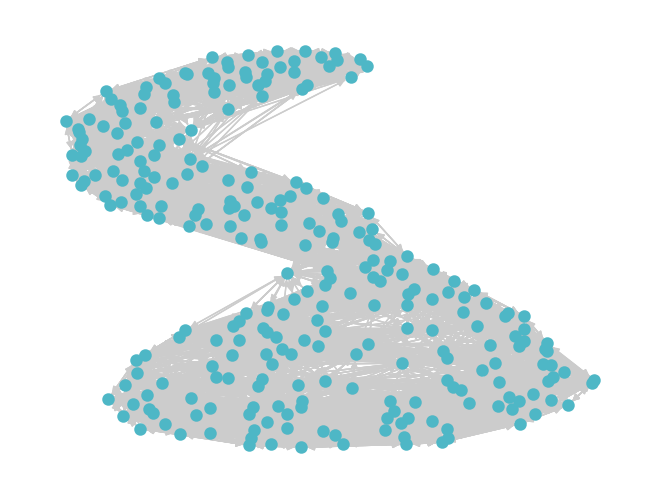

In [14]:
nx_graph = g.to_networkx()

# Plot the graph
pos = nx.spring_layout(nx_graph, seed=0)  # You can use different layout algorithms
nx.draw(nx_graph, pos, with_labels=False, node_color='#4EB7C6', node_size=80, font_size=8, font_color='black', font_weight='normal', edge_color='#CCCCCC', linewidths=0.05)

# Show the plot
plt.show()


In [18]:
loss_df, gat_df = GAT.velocity(gas_erthyroid_cell_df, 
                                gene_list=gene_list,
                                permutation_ratio=0.125,
                                n_jobs=8)


Using /Users/kylelam/Documents/cs/cs2952g/csci2592g-final-project/src/predict/cellDancer_velocity_2023-12-08 18-05-44 as the output path.


Traceback (most recent call last):
  File "/Users/kylelam/Documents/cs/cs2952g/csci2592g-final-project/src/predict/model.py", line 724, in _train_thread
    trainer.fit(model, g)   # train network
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 737, in fit
    self._call_and_handle_interrupt(
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 682, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 772, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 1195, in _run
    self._dispatch()
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/traine

(93, 93)
entering training _train_thread
1 sin
2 sin
3 sin
4 sin
5 sin
An error occurred: Expected data to be int, Sequence or Mapping, but got DGLGraph
Arranging genes for parallel job.
14  genes were arranged to  2  portions.


(130, 130)
entering training _train_thread
1 sin
2 sin
3 sin
4 sin
5 sin
An error occurred: Expected data to be int, Sequence or Mapping, but got DGLGraph


Traceback (most recent call last):
  File "/Users/kylelam/Documents/cs/cs2952g/csci2592g-final-project/src/predict/model.py", line 724, in _train_thread
    trainer.fit(model, g)   # train network
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 737, in fit
    self._call_and_handle_interrupt(
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 682, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 772, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 1195, in _run
    self._dispatch()
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/traine

(145, 145)
(83, 83)
entering training _train_thread
(148, 148)
(97, 97)
1 sin
2 sin
3 sin
4 sin
5 sin
An error occurred: Expected data to be int, Sequence or Mapping, but got DGLGraph
entering training _train_thread
(142, 142)
1 sin
2 sin
3 sin
4 sin
5 sin
An error occurred: Expected data to be int, Sequence or Mapping, but got DGLGraph
entering training _train_thread
entering training _train_thread
1 sin
2 sin
3 sin
4 sin
5 sin
An error occurred: Expected data to be int, Sequence or Mapping, but got DGLGraph
1 sin
2 sin
3 sin
4 sin
5 sin
An error occurred: Expected data to be int, Sequence or Mapping, but got DGLGraph
(59, 59)
entering training _train_thread
(168, 168)
entering training _train_thread
1 sin
2 sin
3 sin
4 sin
5 sin
1 sin
2 sin
3 sin
4 sin
5 sin


Traceback (most recent call last):
  File "/Users/kylelam/Documents/cs/cs2952g/csci2592g-final-project/src/predict/model.py", line 724, in _train_thread
    trainer.fit(model, g)   # train network
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 737, in fit
    self._call_and_handle_interrupt(
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 682, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 772, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 1195, in _run
    self._dispatch()
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/traine

An error occurred: Expected data to be int, Sequence or Mapping, but got DGLGraph
An error occurred: Expected data to be int, Sequence or Mapping, but got DGLGraph
entering training _train_thread
1 sin
2 sin
3 sin
4 sin
5 sin
An error occurred: Expected data to be int, Sequence or Mapping, but got DGLGraph


(93, 93)
(151, 151)
(120, 120)
entering training _train_thread
1 sin
2 sin
3 sin
4 sin
5 sin
An error occurred: Expected data to be int, Sequence or Mapping, but got DGLGraph
(101, 101)
(105, 105)
entering training _train_thread
entering training _train_thread
1 sin
2 sin
3 sin
4 sin
5 sin
An error occurred: Expected data to be int, Sequence or Mapping, but got DGLGraph
(82, 82)
1 sin
2 sin
3 sin
4 sin
5 sin
An error occurred: Expected data to be int, Sequence or Mapping, but got DGLGraph
entering training _train_thread
1 sin
2 sin
3 sin
4 sin
5 sin
An error occurred: Expected data to be int, Sequence or Mapping, but got DGLGraph
entering training _train_thread
1 sin
2 sin
3 sin
4 sin
5 sin
An error occurred: Expected data to be int, Sequence or Mapping, but got DGLGraph
entering training _train_thread
1 sin
2 sin
3 sin
4 sin
5 sin
An error occurred: Expected data to be int, Sequence or Mapping, but got DGLGraph


Traceback (most recent call last):
  File "/Users/kylelam/Documents/cs/cs2952g/csci2592g-final-project/src/predict/model.py", line 724, in _train_thread
    trainer.fit(model, g)   # train network
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 737, in fit
    self._call_and_handle_interrupt(
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 682, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 772, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 1195, in _run
    self._dispatch()
  File "/Users/kylelam/anaconda3/envs/cellDancer/lib/python3.9/site-packages/pytorch_lightning/traine